In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
%matplotlib inline

C:\Users\Blake\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Blake\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)

(26729, 10)
(11456, 8)


In [4]:
test_df.rename(columns={'ID': 'AnimalID'}, inplace=True)

In [5]:
train_df.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [6]:
combined_df = pd.concat([train_df, test_df])

In [7]:
combined_df.isnull().sum()

AgeuponOutcome       24
AnimalID              0
AnimalType            0
Breed                 0
Color                 0
DateTime              0
Name              10916
OutcomeSubtype    25068
OutcomeType       11456
SexuponOutcome        1
dtype: int64

In [8]:
import re
def convert_age(row):
    to_years = int(re.search('\d+', str(row)).group()) if re.search('\d+', str(row)) else None
    if 'year' in str(row):
        return to_years
    elif 'month' in str(row) or 'months' in str(row):
        return round(to_years / 12, 2)
    elif 'day' in str(row) or 'days' in str(row):
        return round(to_years / 365, 2)
    elif 'week' in str(row) or 'weeks' in str(row):
        return round(to_years / 52, 2)

In [9]:
def fill_null_vals(df):
    df.AgeuponOutcome = df.AgeuponOutcome.apply(convert_age)
    df.loc[df.AgeuponOutcome.isnull(), 'AgeuponOutcome'] = df.loc[~df.AgeuponOutcome.isnull(), 'AgeuponOutcome'].median()
    df.loc[df.Name.isnull(), 'Name'] = 'no name'
    df.loc[df.OutcomeSubtype.isnull(), 'OutcomeSubtype'] = 'no subtype'
    df.loc[combined_df.SexuponOutcome.isnull(), 'SexuponOutcome'] = 'Neutered Male'
    return df

In [10]:
combined_df = fill_null_vals(combined_df)

In [11]:
combined_df['AgeCategory'] = pd.cut(combined_df.AgeuponOutcome, 5)

In [12]:
combined_df.Breed = combined_df.Breed.str.lower().str.strip()

In [13]:
combined_df['IsMix'] = combined_df.Breed.str.contains('mix').map({True: 1.0, False: 0.0})
combined_df['IsPitbull'] = combined_df.Breed.str.contains('pit ?bull').map({True: 1.0, False: 0.0})
combined_df['IsShorthair'] = combined_df.Breed.str.contains('short ?hair').map({True: 1.0, False: 0.0})
combined_df['IsChihuahua'] = combined_df.Breed.str.contains('chihuahua').map({True: 1.0, False: 0.0})
combined_df['IsRetriever'] = combined_df.Breed.str.contains('retriever').map({True: 1.0, False: 0.0})
combined_df['IsLabrador'] = combined_df.Breed.str.contains('labrador').map({True: 1.0, False: 0.0})

In [14]:
combined_df.Color = combined_df.Color.str.lower().str.strip()

In [15]:
combined_df['IsBrown'] = combined_df.Color.str.contains('brown').map({True: 1.0, False: 0.0})
combined_df['IsTabby'] = combined_df.Color.str.contains('tabby').map({True: 1.0, False: 0.0})
combined_df['IsBlack/White'] = combined_df.Color.str.contains('black\/white').map({True: 1.0, False: 0.0})
combined_df['IsBlack'] = combined_df.Color.str.contains('black').map({True: 1.0, False: 0.0})
combined_df['IsTabby/White'] = combined_df.Color.str.contains('tabby\/white').map({True: 1.0, False: 0.0})
combined_df['IsBlue'] = combined_df.Color.str.contains('blue').map({True: 1.0, False: 0.0})
combined_df['IsOrange'] = combined_df.Color.str.contains('orange').map({True: 1.0, False: 0.0})
combined_df['IsWhite'] = combined_df.Color.str.contains('white').map({True: 1.0, False: 0.0})
combined_df['IsBrown/White'] = combined_df.Color.str.contains('brown\/white').map({True: 1.0, False: 0.0})

In [16]:
combined_df.drop(['Breed', 'Color'], axis=1, inplace=True)
#drop breed
#drop color

In [17]:
combined_df = pd.get_dummies(combined_df, columns=['OutcomeSubtype', 'SexuponOutcome', 'AgeCategory', 'AnimalType'])

In [18]:
from collections import Counter
top_names = '|'.join(map(lambda x: x[0], sorted(Counter(train_df.Name.str.lower().str.strip()).items(), 
                                key=lambda x: x[1], reverse=True)[1:101]))

In [19]:
combined_df['IsTopName'] = combined_df.Name.str.lower().str.strip().str.contains(top_names).map({True: 1.0, False: 0.0})

In [20]:
combined_df.drop('Name', axis=1, inplace=True)

In [21]:
combined_df.drop(['AnimalID', 'AgeuponOutcome'], axis=1, inplace=True)

In [22]:
datetime_df = combined_df.DateTime.astype(str).str.replace(' .*', '').str.split("-", expand=True)
datetime_df.columns = ['Year', 'Month', 'Day']

In [23]:
combined_df = pd.get_dummies(pd.concat([combined_df, datetime_df], axis=1), columns=['Year', 'Month', 'Day'])

In [24]:
combined_df.drop(['DateTime'], axis=1, inplace=True)

In [25]:
combined_df.shape

(38185, 93)

In [26]:
train_df = combined_df[:26729]
test_df = combined_df[26729:]
train_df.OutcomeType = LabelEncoder().fit_transform(train_df.OutcomeType)

C:\Users\Blake\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
y = train_df.OutcomeType
X = train_df.ix[:, filter(lambda x: x != 'OutcomeType', train_df.columns)]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [30]:
preds = rfc.predict_proba(X_test)

In [31]:
log_loss(y_test, preds)

0.30133685396494697

In [32]:
rfc_feat_importances = pd.DataFrame(sorted(zip(X.columns, rfc.feature_importances_), key=lambda x: x[1], reverse=True), 
                                   columns=['Feature Name', 'Level of Importance'])

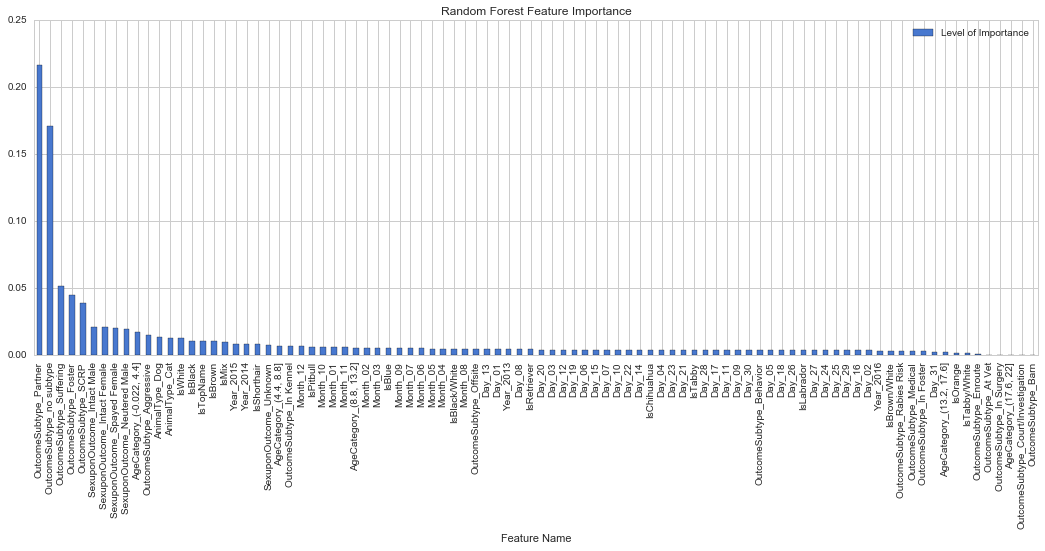

In [33]:
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("muted", 10))
rfc_feat_importances.plot(kind='bar', x='Feature Name', y='Level of Importance', 
                          figsize=(18, 6), title='Random Forest Feature Importance');